In [54]:
#!pip install ftfy regex tqdm -qq
#!pip install git+https://github.com/openai/CLIP.git -qq
#!pip install validators matplotlib -qq
#!pip install efficientnet_pytorch -qq

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# linear algebra
import numpy as np

#base
# Plot result
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import gc
import os
import matplotlib.image as mpimg
import json
import requests
from glob import glob
from tqdm import tqdm
from collections import defaultdict

#clustering
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster  import DBSCAN, OPTICS, KMeans
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn import metrics
#computer vision
import cv2

# libs for efficientnet
import torch
import torch.nn as nn
import torch.optim as optim 
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torch.utils.data import DataLoader
import torchvision.transforms as T
import clip
#EfficientNet
from efficientnet_pytorch import EfficientNet
import pickle

# Config

In [3]:
IMG_SIZE = 224 # use this param to resize cropped images
data_dir = 'tests'
train_dir = data_dir + 'tests'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
PROJECT_PATH = os.path.abspath("../../")
print(f'Using {device} for inference')
print(f'Project path: {PROJECT_PATH}')

Using cpu for inference
Project path: /Users/guskov/Developer/ML/shelves_detector


In [4]:
transforms = T.Compose([T.ToPILImage(),T.Resize((IMG_SIZE,IMG_SIZE)), T.ToTensor()])

# Helpers

In [5]:
def similarity_score( model, transform, img_path_a, img_path_b, device='cpu'):
    '''
    model - uses to extract features
    A - img looking for similariest img
    B - one of iter img from all_images
    '''
    if 'EfficientNet' in  model.__class__.__name__:
        model.eval().to(device)
        a = mpimg.imread(img_path_a)
        #a = Image.open(img_path_a)
        a = transform(a)
        a = a.unsqueeze( 0)
        a_features = model.extract_features(a.to(device))
        a_features = torch.nn.functional.adaptive_avg_pool2d(a_features, 1)
        #print(a_features.shape)
        if len(a_features.shape) == 4:
            a_features = a_features.squeeze(2).squeeze(2)
            a_features /= a_features.norm(dim=-1, keepdim=True)
        #print(a_features.shape)
        b = mpimg.imread(img_path_b)
        #b = Image.open(img_path_b)
        b = transform(b)
        b = b.unsqueeze(0)
        b_features = model.extract_features(b.to(device))
        #print(b_features.shape)
        b_features = torch.nn.functional.adaptive_avg_pool2d(b_features, 1)

        if len(b_features.shape) == 4:
            b_features = b_features.squeeze(2).squeeze(2)
            b_features /= b_features.norm(dim=-1, keepdim=True)

        similarity = (100.0 * a_features @ b_features.T).squeeze(-1).squeeze(-1).cpu().detach().numpy()
    else:
    #if 'CLIP' in model.__class__.__name__:
        model.eval().to(device)
        a = Image.open(img_path_a)
        b = Image.open(img_path_b)
        a = transform(a).unsqueeze(0).to(device)
        b = transform(b).unsqueeze(0).to(device)
        
        # Calculate features
        a_features = model.encode_image(a)
        b_features = model.encode_image(b)  
        
        a_features /= a_features.norm(dim=-1, keepdim=True)
        b_features /= b_features.norm(dim=-1, keepdim=True)        

        # Just user all image from 
        similarity = (100.0 * a_features @ b_features.T).squeeze(-1).squeeze(-1).cpu().detach().numpy() #.softmax(dim=-1)
    return similarity        

In [59]:
def vectorize_image(model, transforms, img_path, device):
    '''
    @model - efficientnet-like models
    img_path - path to img
    
    return = img_path, image_embedding
    '''

    if 'EfficientNet' in model.__class__.__name__:
        model.eval().to(device)
        a = mpimg.imread(img_path)
        a = transforms(a)
        a = a.unsqueeze(0)
        a_features = model.extract_features(a.to(device))
        a_features = torch.nn.functional.adaptive_avg_pool2d(a_features, 1)
        if len(a_features.shape) == 4:
            a_features = a_features.squeeze(2).squeeze(2).squeeze(0)
            a_features /= a_features.norm(dim=-1, keepdim=True)
    else:
        model.eval().to(device)
        img = Image.open(img_path)
        img = transforms(img).unsqueeze(0).to(device)
        # Calculate features
        a_features = model.encode_image(img)
        a_features = a_features.squeeze(0)
        a_features /= a_features.norm(dim=-1, keepdim=True)        

    return img_path, a_features.cpu().detach().numpy()

In [7]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
def get_images(all_images):
    images = []
    images.extend([get_image(img_name) for img_name in all_images])
    return np.array(images)

In [120]:
def path_changer(path_to_detected : str, local_path : str):
	final_img_path =os.path.join(os.path.dirname(local_path).split('/')[-1], os.path.basename(local_path))
	return os.path.join(PROJECT_PATH, path_to_detected, final_img_path)

# VIT CLIP - [Github clip](https://github.com/openai/CLIP)

In [64]:
# Load the model

model_clip, preprocess = clip.load('ViT-B/32', device)
print(model_clip.__class__.__name__, "loaded")

RecursiveScriptModule loaded


# EfficientNet b0

In [14]:
# Specify a path
PATH = "efficientnet_b0.pt"
model_effnetb0 = EfficientNet.from_pretrained('efficientnet-b0')
model_effnetb0.eval().to(device)
print(model_effnetb0.__class__.__name__, "loaded")
torch.save(model_effnetb0.state_dict(), f'{PROJECT_PATH}/model/{PATH}')
torch.save(model_effnetb0,f'{PROJECT_PATH}/model/{PATH}')

Loaded pretrained weights for efficientnet-b0
EfficientNet loaded


## EfficientNet b1

In [66]:
model_effnetb1 = EfficientNet.from_pretrained('efficientnet-b1')
model_effnetb1.eval().to(device)
print(model_effnetb1.__class__.__name__, "loaded")

Loaded pretrained weights for efficientnet-b1
EfficientNet loaded


## EfficientNet b5

In [67]:
model_effnetb5 = EfficientNet.from_pretrained('efficientnet-b5')
model_effnetb5.eval().to(device)
print(model_effnetb5.__class__.__name__, "loaded")

Loaded pretrained weights for efficientnet-b5
EfficientNet loaded


In [ ]:
'''
class ImageData(Dataset):
    def __init__(self,data_dir, transform):
        super().__init__()
        #self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.data_dir))#len(self.df)
    
    def __getitem__(self, index):       
        img_name = os.path.basename(os.listdir(self.data_dir)[index])
        #print(img_name)
        #label = self.df.has_cactus[index]
        
        img_path = os.path.join(self.data_dir, img_name)
        image = mpimg.imread(img_path)
        image = self.transform(image)
        return image #, label

data_transf = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
train_data = ImageData( data_dir = train_dir, transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size =1)    



test_image = next(iter(train_loader))
test_image.shape
test_image = test_image.unsqueeze(0)
torch.unsqueeze(test_image.shape, 0)
# 1 st method
features = model.extract_features(test_image)
pooled_features = torch.nn.functional.adaptive_avg_pool2d(features, 1)
print(pooled_features.shape)

# 2 nd method
t_model = model
t_model._fc = torch.nn.Identity()
t_features = t_model.extract_features(test_image)

print(t_features.shape)
print(torch.eq(pooled_features, t_features))

next(iter(train_loader))[0]
'''

In [48]:
TEST_IMAGE = f'{PROJECT_PATH}/goods/photo_2020-11-15_15-26-15/0_0.jpg'
all_images = glob(f'{PROJECT_PATH}/goods/*/*.jpg')
print("Len of cropped images:", len(all_images))

Len of cropped images: 8791


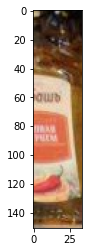

In [49]:
img = cv2.imread(TEST_IMAGE)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
plt.show()

In [77]:
%%time
similarity_score( model_effnetb1,transforms, TEST_IMAGE, TEST_IMAGE, device)
#similarity_score(model_effnetb0, transforms,  TEST_IMAGE, TEST_IMAGE, device)

CPU times: user 1.71 s, sys: 514 ms, total: 2.22 s
Wall time: 407 ms


array(100.00005, dtype=float32)

In [61]:
%%time
similarity_score( model_clip, preprocess, TEST_IMAGE, TEST_IMAGE, device)

CPU times: user 2.44 s, sys: 202 ms, total: 2.64 s
Wall time: 583 ms


array(100.00003, dtype=float32)

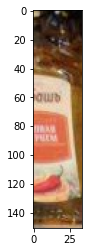

In [68]:
img = cv2.imread(TEST_IMAGE)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
plt.show()

# Get Dict with image embeddings from efficientnets

# Get effnetb0 img embedding

In [ ]:
%%time
#img_embedding_effnetb0_dict = {}
#for img_path in tqdm(all_images):
#    img_path, features = vectorize_image(model_effnetb0, transforms, img_path,device)
#    img_embedding_effnetb0_dict[img_path] = features
#    gc.collect()
#img_embedding_effnetb0_dict.values()

# Get CLIP img embedding

In [ ]:
# Next cells take a long time

In [ ]:
#%%time

#img_embedding_clip_dict = {}
#for img_path in tqdm(all_images):
#    img_path, features = vectorize_image(model_clip, preprocess, img_path,device)
#    img_embedding_clip_dict[img_path] = features
#    gc.collect()
#len(img_embedding_clip_dict)

# Get effnetb5 img embedding

In [ ]:
#%%time
#img_embedding_effnetb5_dict = {}
#for img_path in tqdm(all_images):
#    img_path, features = vectorize_image(model_effnetb5, transforms, img_path,device)
#    img_embedding_effnetb5_dict[img_path] = features
#    gc.collect()
#len(img_embedding_effnetb5_dict.values())

In [83]:
# save into pickle

#with open('img_embedding_CLIP_dict_IMG_224.pickle', 'wb') as handle:
#    pickle.dump(img_embedding_clip_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load from pickle
with open(f'{PROJECT_PATH}/research/vectorize_hypothesis/embeddings/img_embedding_CLIP_dict_IMG_224.pickle', 'rb') as handle:
    img_embedding_clip_dict = pickle.load(handle)
print(len(img_embedding_clip_dict.values()))    

8791


In [84]:
# save into pickle

#with open('img_embedding_effnetb5_dict_IMG_224.pickle', 'wb') as handle:
#    pickle.dump(img_embedding_effnetb5_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# load from pickle
with open(f'{PROJECT_PATH}/research/vectorize_hypothesis/embeddings/img_embedding_effnetb5_dict_IMG_224.pickle', 'rb') as handle:
    img_embedding_effnetb5_dict = pickle.load(handle)
print(len(img_embedding_effnetb5_dict.values()))      

8791


In [85]:
# save into pickle
#
#with open('img_embedding_effnetb0_dict_IMG_224.pickle', 'wb') as handle:
#    pickle.dump(img_embedding_effnetb0_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open(f'{PROJECT_PATH}/research/vectorize_hypothesis/embeddings/img_embedding_effnetb0_dict_IMG_224.pickle', 'rb') as handle:
    img_embedding_effnetb0_dict = pickle.load(handle)
print(len(img_embedding_effnetb0_dict.values()))  	

8791


# Get effnetb1 img embedding

In [ ]:
#%%time
#img_embedding_effnetb1_dict = {}
#for img_path in tqdm(all_images):
#    img_path, features = vectorize_image(model_effnetb1,transforms, img_path,device)
#    img_embedding_effnetb1_dict[img_path] = features
#    gc.collect()

In [87]:
#SAVE
#with open('img_embedding_effnetb1_dict_IMG_224.pickle', 'wb') as handle:
#    pickle.dump(img_embedding_effnetb1_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#LOAD    
with open(f'{PROJECT_PATH}/research/vectorize_hypothesis/embeddings/img_embedding_effnetb1_dict_IMG_224.pickle', 'rb') as handle:
    img_embedding_effnetb1_dict = pickle.load(handle) 
print(len(img_embedding_effnetb1_dict.values()))        

8791


# KNN

In [88]:
def show_k_nearest_neigbours(k:'k' , image_path,model, transforms,dict_embeddings, device):
    knn = NearestNeighbors(metric='cosine' ,algorithm='brute',n_jobs=-1) #
    vecs = np.array(list(dict_embeddings.values()))
    knn.fit(vecs)
    filenames = np.array(list(dict_embeddings.keys()))
    vec = vectorize_image(model,transforms, image_path, device)[1].reshape(1, -1)
    dist, indices = knn.kneighbors(vec, n_neighbors=k)
    similar_images = [(filenames[indices[i]], dist[i]) for i in range(len(indices))]
    return similar_images

In [ ]:
#knn = NearestNeighbors(metric='cosine' ,algorithm='brute',n_jobs=-1) #
#vecs = np.array(list(img_embedding_clip_dict.values()))
#knn.fit(vecs)

In [90]:
test_image = f'{PROJECT_PATH}/goods/photo_2021-08-13_19-27-15/5_0.jpg'#'../input/goods-detection/goods/goods/photo_2020-11-15_15-26-15/0_0.jpg'
clip_neibours = show_k_nearest_neigbours( 4, test_image, model_clip,preprocess,img_embedding_clip_dict, device)
effnetb1_neibours = show_k_nearest_neigbours( 4, test_image, model_effnetb1,transforms,img_embedding_effnetb1_dict, device)
effnetb0_neibours = show_k_nearest_neigbours( 4, test_image, model_effnetb0,transforms,img_embedding_effnetb0_dict, device)
effnetb5_neibours = show_k_nearest_neigbours( 4, test_image, model_effnetb5,transforms,img_embedding_effnetb5_dict, device)

In [91]:
clip_neibours

[(array(['../input/goods-detection/goods/goods/photo_2021-08-13_19-27-15/5_0.jpg',
         '../input/goods-detection/goods/goods/photo_2021-08-13_19-27-15/5_1.jpg',
         '../input/goods-detection/goods/goods/photo_2021-08-13_19-27-15/2_2.jpg',
         '../input/goods-detection/goods/goods/photo_2022-02-11_18-01-05/2_1.jpg'],
        dtype='<U75'),
  array([0.01636573, 0.09764919, 0.1580343 , 0.19803411]))]

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2021-08-13_19-27-15/5_0.jpg


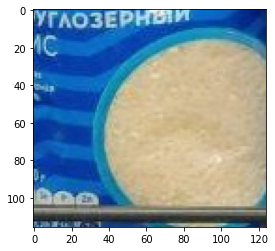

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2021-08-13_19-27-15/5_1.jpg


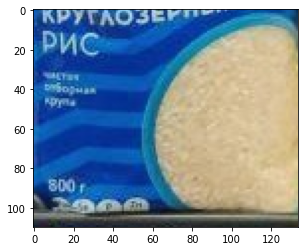

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2021-08-13_19-27-15/2_2.jpg


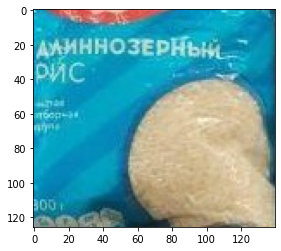

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2022-02-11_18-01-05/2_1.jpg


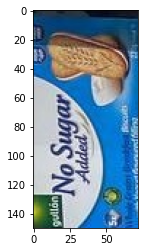

In [121]:
for img_path in clip_neibours[0][0]:
    img_path = path_changer("goods",local_path=img_path)
    print(img_path)
    img = get_image(img_path)
    plt.imshow(img)
    plt.show()

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2021-08-13_19-27-15/5_0.jpg


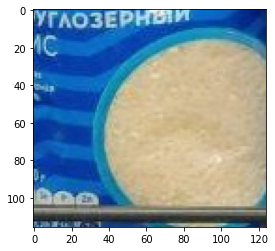

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2021-08-13_19-27-15/5_1.jpg


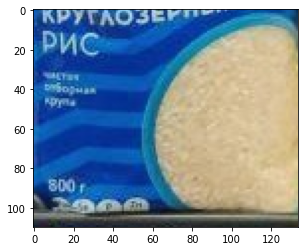

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2022-02-11_17-31-28 (2)/3_10.jpg


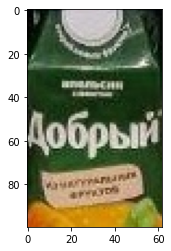

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2022-02-11_18-01-05/1_4.jpg


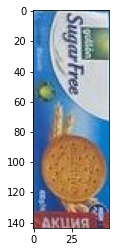

In [122]:
for img_path in effnetb1_neibours[0][0]:
    img_path = path_changer("goods",local_path=img_path)
    print(img_path)
    img = get_image(img_path)
    plt.imshow(img)
    plt.show()

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2021-08-13_19-27-15/5_0.jpg


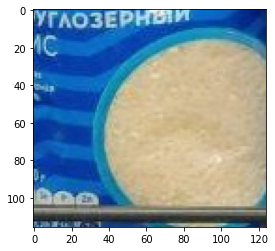

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2021-08-13_19-27-15/5_1.jpg


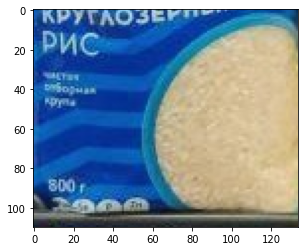

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2022-02-11_18-15-40/3_22.jpg


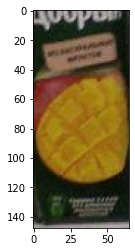

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2021-08-13_19-27-15/2_2.jpg


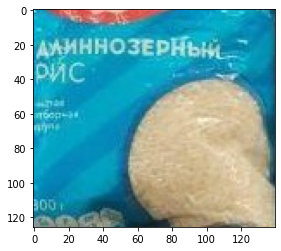

In [123]:
for img_path in effnetb0_neibours[0][0]:
    img_path = path_changer("goods",local_path=img_path)
    print(img_path)
    img = get_image(img_path)
    plt.imshow(img)
    plt.show()

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2021-08-13_19-27-15/5_0.jpg


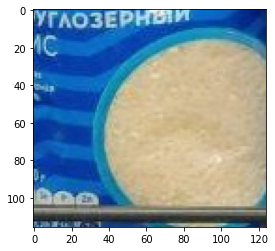

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2021-08-13_19-27-15/5_1.jpg


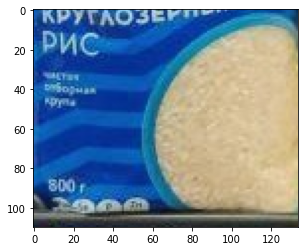

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2022-02-11_18-01-23/3_0.jpg


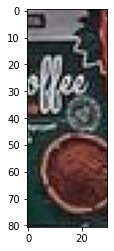

/Users/guskov/Developer/ML/shelves_detector/goods/photo_2022-02-11_18-01-05/1_4.jpg


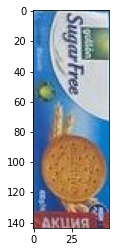

In [124]:
for img_path in effnetb5_neibours[0][0]:
    img_path = path_changer("goods",local_path=img_path)
    print(img_path)
    img = get_image(img_path)
    plt.imshow(img)
    plt.show()

# DBSCAN

In [125]:
%%time

X = np.array(list(img_embedding_effnetb0_dict.values()))

db = DBSCAN(metric='cosine',n_jobs=-1).fit(X)
print(db.labels_)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

[0 0 0 ... 0 0 0]
Estimated number of clusters: 1
Estimated number of noise points: 0
CPU times: user 7.67 s, sys: 2.28 s, total: 9.95 s
Wall time: 2.6 s


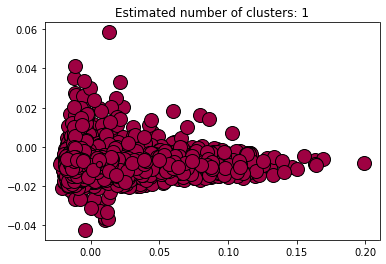

In [126]:


# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

# Scalar Multiplication of similarity
*  Need threshold

In [127]:
threshold = 70

In [128]:
%%time
test_image = f'{PROJECT_PATH}/goods/photo_2020-11-15_15-26-15/0_0.jpg'
count = 0
similar_imgs = []
for ind, image_path in tqdm(enumerate(all_images), total=len(all_images)):
    similarity = similarity_score( model_effnetb0, transforms, test_image, image_path, device)
    if similarity.item() > threshold:
        similar_imgs.append(image_path)
        count += 1
        if count > 0 and count % 10 == 0:
            print(count)

  1%|          | 94/8791 [00:19<30:24,  4.77it/s]


KeyboardInterrupt: 

In [ ]:
for img_path in similar_imgs:
    img_path = path_changer("goods",local_path=img_path)
    print(img_path)
    img = get_image(img_path)
    plt.imshow(img)
    plt.show()

# How to merge bounding boxes
1. Non-Maximum Suppression.

 - Score each box, and then do the following:
 - Find all boxes whose IOUs with the highest scored box are greater than some threshold (typically 0.5);
 - Remove all these boxes.
 - Continue this procedure for the rest boxes.